## OpenAI Whisper

To get started, we'll first install the OpenAI Whisper Python package using pip.

In [1]:
!pip install git+https://github.com/openai/whisper.git -q


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.3 MB/s eta 0:00:00


We'll also make sure we have a GPU available in Google Colab. If you don't have a GPU, go to Runtime -> Change Runtime Type -> Hardware Accelator and select GPU. I have Colab Pro so I get access to Premium GPU's. Run the command below to show which GPU is being used in the current runtime:

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e3f6c9bd-8d61-b363-7576-a2f188a66ae1)


Whisper transcribes audio speech to text. To see this in action, we'll need some audio to operate on. We'll extract some audio from a YouTube video using the pytube Python package. let's install it with pip.

In [ ]:
!pip install pytube -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.4 MB/s eta 0:00:00


Now that we have installed the dependencies, let's import whisper and the YouTube class from pytube.

In [ ]:
from pytube import YouTube
import whisper

Whisper has a variety of models of varying sizes. The large model will be more accurate but will also be more resource intensive.

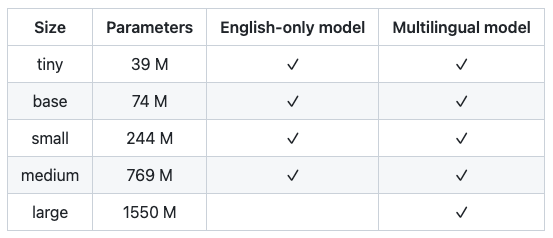

The base model will be sufficient for our needs. Let's load the base model like so:

In [ ]:
model = whisper.load_model('base')

100%|███████████████████████████████████████| 139M/139M [00:03<00:00, 42.0MiB/s]


We'll now instantiate a "YouTube" object by passing in the video URL. This will allow us to retrieve metadata and stream info about the specified YouTube URL.

In [ ]:
youtube_video_url = "https://www.youtube.com/watch?v=NT2H9iyd-ms"
youtube_video = YouTube(youtube_video_url)

Now that we have an pytube YouTube object, let's explore some of its attributes.

In [ ]:
youtube_video.title


'WATCH LIVE | Fed Chair Powell Discusses Latest Fed Rate Hike'

In [ ]:
dir(youtube_video)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_age_restricted',
 '_author',
 '_embed_html',
 '_fmt_streams',
 '_initial_data',
 '_js',
 '_js_url',
 '_metadata',
 '_player_config_args',
 '_publish_date',
 '_title',
 '_vid_info',
 '_watch_html',
 'age_restricted',
 'allow_oauth_cache',
 'author',
 'bypass_age_gate',
 'caption_tracks',
 'captions',
 'channel_id',
 'channel_url',
 'check_availability',
 'description',
 'embed_html',
 'embed_url',
 'fmt_streams',
 'from_id',
 'initial_data',
 'js',
 'js_url',
 'keywords',
 'length',
 'metadata',
 'publish_date',
 'rating',
 'register_on_complete_callback',
 'register_on_progress_callback',
 'stream_monostate',
 'streamin

As you can see, we have a list of video and audio streams of varying quality. We can iterate over this list and observe the different resolutions and framerates.

For this tutorial, we are interested in the audio channel only. Thus, we will filter down to audio streams only.

In [ ]:
for stream in youtube_video.streams:
  print (stream)

<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="7fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">
<Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">
<Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">
<St

We don't need the highest quality audio for this project, so we'll select the first audio stream available. If we want a higher quality transcription, we can select a higher quality audio stream and use a larger Whisper model.

In [ ]:
youtube_video.streams.filter(only_audio=True).order_by('abr').first()

<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">

In [ ]:
stream = youtube_video.streams.filter(only_audio=True).order_by('abr').first().download(filename='fed_meeting.mp4')
stream


'/content/fed_meeting.mp4'

Now that we have selected stream we are working with, let's download the stream as fed_meeting.mp4. You should see the file appear in the filesystem browser on the side panel of Colab. Click the refresh button if you don't see it after a while.

We can do some additional processing on the audio file should we choose. I want to ignore any additional sound and speech after Jerome Powell speaks. So we'll use ffmpeg to do this. The command will start the audio file at the 375 second mark where he starts with good afternoon, continue for 2715 seconds, and chop off the rest of the audio. The result will be saved in a new file called fed_meeting_trimmed.mp4.

In [ ]:
!ffmpeg -ss 378 -i fed_meeting.mp4 -t 1000 fed_meeting_trimmed.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

It is possible to embed an audio player into Google Colab, but will not do this for now since I have seen the runtime get disconnected on large audio files. If you want a copy of the resulting audio, you can download it locally using the Colab the file browser.

In [ ]:
import datetime

# save a timestamp before transcription
t1 = datetime.datetime.now()
print(f"started at {t1}")

# do the transcription
output = model.transcribe("fed_meeting_trimmed.mp4")

# show time elapsed after transcription is complete.
t2 = datetime.datetime.now()
print(f"ended at {t2}")
print(f"time elapsed: {t2 - t1}")

started at 2023-06-11 00:06:08.298448
ended at 2023-06-11 00:07:06.735095
time elapsed: 0:00:58.436647


In [ ]:
output

{'text': " Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2% goal. We have both the tools that we need and the resolve it will take to restore price stability on behalf of American families and businesses. Price stability is the responsibility of the Federal Reserve and serves as the bedrock of our economy. Without price stability, the economy does not work for anyone. In particular, without price stability, we will not achieve a sustained period of strong labor market conditions that benefit all. Today, the FOMC raised our policy interest rate by 75 basis points and we continue to anticipate that ongoing increases will be appropriate. We are moving our policy stance purposefully to a level that will be sufficiently restrictive to return inflation to 2%. In addition, we are continuing the process of significantly reducing the size of our balance sheet. Restoring price stability will likely require maintaining a restrictive stance of po

In [ ]:
output['text']

" Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2% goal. We have both the tools that we need and the resolve it will take to restore price stability on behalf of American families and businesses. Price stability is the responsibility of the Federal Reserve and serves as the bedrock of our economy. Without price stability, the economy does not work for anyone. In particular, without price stability, we will not achieve a sustained period of strong labor market conditions that benefit all. Today, the FOMC raised our policy interest rate by 75 basis points and we continue to anticipate that ongoing increases will be appropriate. We are moving our policy stance purposefully to a level that will be sufficiently restrictive to return inflation to 2%. In addition, we are continuing the process of significantly reducing the size of our balance sheet. Restoring price stability will likely require maintaining a restrictive stance of policy for 

In [ ]:
for segment in output['segments']:
  print(segment)
  second = int(segment['start'])
  second = second - (second % 5)
  print(second)

{'id': 0, 'seek': 0, 'start': 0.0, 'end': 8.0, 'text': ' Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2% goal.', 'tokens': [50364, 2205, 6499, 13, 1222, 7734, 293, 286, 366, 10613, 7784, 281, 5062, 15860, 646, 760, 281, 527, 568, 4, 3387, 13, 50764], 'temperature': 0.0, 'avg_logprob': -0.1440937325761125, 'compression_ratio': 1.5818181818181818, 'no_speech_prob': 0.06528296321630478}
0
{'id': 1, 'seek': 0, 'start': 8.0, 'end': 16.0, 'text': ' We have both the tools that we need and the resolve it will take to restore price stability on behalf of American families and businesses.', 'tokens': [50764, 492, 362, 1293, 264, 3873, 300, 321, 643, 293, 264, 14151, 309, 486, 747, 281, 15227, 3218, 11826, 322, 9490, 295, 2665, 4466, 293, 6011, 13, 51164], 'temperature': 0.0, 'avg_logprob': -0.1440937325761125, 'compression_ratio': 1.5818181818181818, 'no_speech_prob': 0.06528296321630478}
5
{'id': 2, 'seek': 0, 'start': 16.0, 'end': 22.0, 'tex

## Combining Speech Data with Price Data

Now that we have this speech and the associated timestamps, we can go further by merging these segments into a dataframe containing price data. Let's see how the speech maps to the price of the S&P 500. I have retrieved 5 second OHLCV data for SPY using Interactive Brokers. A copy of this data and the code used to retrieve it are located on the website. We can upload spy.csv to Colab and process it using pandas.

In [ ]:
import pandas as pd

In [ ]:
spy = pd.read_csv("spy.csv")


In the dataframe below, you can see the open, high, low, and close for each 5 second time period that occurred during the speech.

In [ ]:
spy

,date,open,high,low,close,volume,average,barCount
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130
...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139


Since we already have the segments of the speech and their start and end times in seconds, we can add a new column containing the text that was spoken during each 5 second bar.

In [ ]:
for segment in output['segments']:
   second = int(segment['start'])
   second = second - (second % 5)
   spy.loc[second / 5, 'text'] = segment['text']

spy


,date,open,high,low,close,volume,average,barCount,text
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444,Good afternoon. My colleagues and I are stron...
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234,We have both the tools that we need and the r...
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232,NaN
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190,Price stability is the responsibility of the ...
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130,"Without price stability, the economy does not..."
...,...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265,"At the same time, now you see services inflat..."
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221,and I just think that the inflation picture
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69,over the course of this year without question.
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139,"and that narrows the path to a soft landing, ..."


Let's also create a new column called *percent* that stores the percent the price moved during the 5 second period.

In [ ]:
spy['percent'] = ((spy['close'] - spy['open']) / spy['open']) * 100

In [ ]:
spy

,date,open,high,low,close,volume,average,barCount,text,percent
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444,Good afternoon. My colleagues and I are stron...,-0.077493
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234,We have both the tools that we need and the r...,0.028438
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232,NaN,-0.077531
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190,Price stability is the responsibility of the ...,0.056900
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130,"Without price stability, the economy does not...",-0.010338
...,...,...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265,But it's not to the extent we had hoped at th...,0.023666
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221,NaN,0.021032
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69,NaN,-0.015771
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139,NaN,-0.005258


We can now filter our dataframe to show bars where the price moved more than a certain percentage. To see where price moved down substantially in a 5 second period, we can filter like so:

In [ ]:
big_downmoves = spy[spy.percent < -0.2]

In [ ]:
big_downmoves

,date,open,high,low,close,volume,average,barCount,text,percent
61,2022-11-02 14:36:20,387.74,387.84,386.42,386.45,214600.0,387.037,1225,NaN,-0.332697
62,2022-11-02 14:36:25,386.40,386.44,385.36,385.52,289403.0,385.919,1731,"At some point, as I've said in the last two p...",-0.227743
78,2022-11-02 14:37:45,383.70,383.70,382.90,382.93,152778.0,383.279,805,"To conclude, we understand that our actions a...",-0.200678
93,2022-11-02 14:39:00,383.67,383.69,382.82,382.83,64429.0,383.275,405,How will we know that we've reached that level?,-0.218938
154,2022-11-02 14:44:05,385.86,385.87,385.07,385.08,73029.0,385.440,486,NaN,-0.202146


Let's quickly visualize this and zoom in on 14:36 using mplfinance:

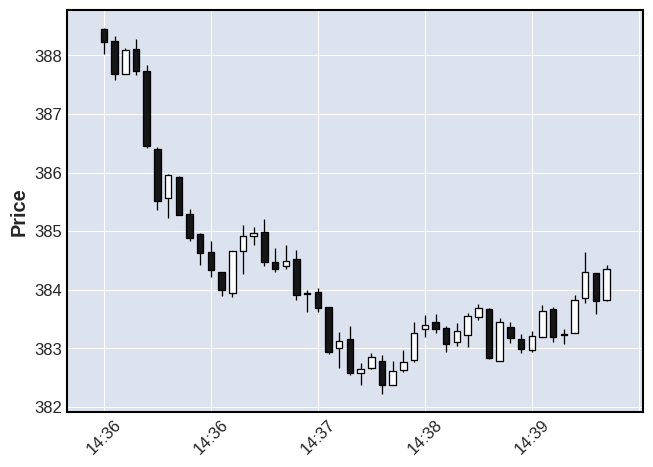

In [ ]:
!pip install mplfinance -q
import mplfinance as mpf

df = spy
df.index = pd.DatetimeIndex(df['date'])

mpf.plot(df['2022-11-02 14:36':'2022-11-02 14:39'],type='candle')



As we can see above, price moved significantly starting at 14:36 (row 61), so we can see the words spoken that led up to this:

In [ ]:
spy[50:70]

,date,open,high,low,close,volume,average,barCount,text,percent
50,2022-11-02 14:35:25,386.91,387.24,386.88,387.19,24625.0,387.125,181,NaN,0.072368
51,2022-11-02 14:35:30,387.21,387.81,387.20,387.77,97840.0,387.514,688,NaN,0.144624
52,2022-11-02 14:35:35,387.73,387.93,387.63,387.65,95192.0,387.808,475,"With today's action, we've raised interest ra...",-0.020633
53,2022-11-02 14:35:40,387.64,387.76,387.52,387.55,30898.0,387.617,162,We anticipate that ongoing increases in the t...,-0.023217
54,2022-11-02 14:35:45,387.56,388.19,387.56,388.16,148005.0,388.015,823,NaN,0.154815
55,2022-11-02 14:35:50,388.15,388.63,388.14,388.22,154486.0,388.446,883,NaN,0.018034
56,2022-11-02 14:35:55,388.25,388.46,388.02,388.42,51105.0,388.253,320,Financial conditions have tightened significa...,0.043786
57,2022-11-02 14:36:00,388.46,388.47,388.02,388.23,61893.0,388.204,368,NaN,-0.059208
58,2022-11-02 14:36:05,388.24,388.34,387.58,387.69,93311.0,387.940,520,"It will take time, however, for the full effe...",-0.141665
59,2022-11-02 14:36:10,387.69,388.12,387.69,388.10,65169.0,387.898,304,That's why we say in our statement that in de...,0.105755
